In [3]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from scipy.optimize import minimize

In [4]:
class LinearMDP_train():
    def __init__(self, action_space, delta, xi_norm, seed=1):
        np.random.seed(seed)
        self.state_space = ['x1', 'x2', 'x3', 'x4', 'x5']
        self.action_space = action_space
        self.initial_state = 'x1'
        self.theta = [np.zeros(4), 
                      np.array([0,0,0,1]), 
                      np.array([0,0,0,1])]
        self.delta = delta
        Xi = np.full(len(self.action_space[0]), 1)
        self.Xi = xi_norm * Xi / np.linalg.norm(Xi, 1)

    def reset(self):
        self.S = [self.initial_state]
        self.A = [] # save the action history
        self.R = [] # save the reward history
        self.h = 0 # reset the step to 0
        self.feature = [] # save the feature trajectory
        self.feature_a = [] # save the full feature trajectory
        self.current_state = self.initial_state  # reset the current state to initial state
    
    def phi(self, current_state, A):
        if current_state == 'x1':
            phi = np.array([1 - self.delta - self.Xi @ A, 0, 0, self.delta + self.Xi @ A])
        elif current_state == 'x2':
            phi = np.array([0, 1 - self.delta - self.Xi @ A, 0, self.delta + self.Xi @ A])
        elif current_state == 'x3':
            phi = np.array([0, 0, 1- self.delta - self.Xi @ A, self.delta + self.Xi @ A])
        elif current_state == 'x4':
            phi = np.array([0,0,1,0])
        else:
            phi = np.array([0,0,0,1])
        return phi

    def add_state(self, s): 
        self.S.append(s)
        self.current_state = s

    def update_state(self, phi, h):
        # claculate the transition probability
        if h == 0:
            prob = [phi[0] * (1-0.001), 0, phi[0]* 0.001, phi[3]]
        elif h == 1:
            if phi[2] == 1:
                prob = [0, 0, 1, 0]
            elif phi[3] == 1:
                prob = [0, 0, 0, 1]
            else:
                prob = [0, phi[1] * (1 - 0.001), phi[1]* 0.001, phi[3]]
        else:
            prob = [0, 0, phi[2], phi[3]]
        sprime = np.random.choice(range(1,5), size=1, p=prob)[0]
        return self.state_space[sprime] # return a string

    def next_state(self, phi):
        next_state = self.update_state(phi, self.h)
        self.add_state(next_state)
        return next_state

    def generate_reward(self, phi):
        reward = np.dot(phi, self.theta[self.h])
        self.R.append(reward)
        return reward

    def step(self, a):
        self.A.append(a)
        phi = self.phi(self.current_state, a)
        phi_a = [self.phi(self.current_state, a) for a in self.action_space]
        self.feature.append(phi)
        self.feature_a.append(phi_a)
        self.generate_reward(phi)
        self.next_state(phi)
        self.h += 1
    
class LinearMDP_test():
    """Pertubed environment"""
    def __init__(self, nominal_MDP, q, seed=1):
        np.random.seed(seed)
        self.state_space = nominal_MDP.state_space
        self.action_space = nominal_MDP.action_space
        self.initial_state = 'x1'
        self.theta = nominal_MDP.theta
        self.delta = nominal_MDP.delta
        self.Xi = nominal_MDP.Xi
        self.q = q

    def reset(self):
        self.S = [self.initial_state] # save the feature trajectory
        self.A = [] # save the action history
        self.R = [] # save the reward history
        self.h = 0 # reset the step to 0
        self.feature = [] # save the feature trajectory
        self.feature_a = [] # save the full feature trajectory
        self.current_state = self.initial_state  # reset the current state to initial state

    def phi(self, current_state, A):
        if current_state == 'x1':
            phi = np.array([1 - self.delta - self.Xi @ A, 0, 0, self.delta + self.Xi @ A])
        elif current_state == 'x2':
            phi = np.array([0, 1 - self.delta - self.Xi @ A, 0, self.delta + self.Xi @ A])
        elif current_state == 'x3':
            phi = np.array([0, 0, 1- self.delta - self.Xi @ A, self.delta + self.Xi @ A])
        elif current_state == 'x4':
            phi = np.array([0,0,1,0])
        else:
            phi = np.array([0,0,0,1])
        return phi

    def add_state(self, s): 
        self.S.append(s)
        self.current_state = s

    def update_state(self, phi, h):
        # claculate the transition probability --- perturbed
        if h == 0:
            prob = [phi[0], 0, self.q * phi[3], (1 - self.q) * phi[3]]
        elif h == 1:
            if phi[2] == 1:
                prob = [0, 0, 1, 0]
            elif phi[3] == 1:
                prob = [0, 0, 0, 1]
            else:
                prob = [0, phi[1] * (1 - 0.001), phi[1]* 0.001, phi[3]]
        else:
            prob = [0, 0, phi[2], phi[3]]
        sprime = np.random.choice(range(1,5), size=1, p=prob)[0]
        return self.state_space[sprime] # return a string

    def next_state(self, phi):
        next_state = self.update_state(phi, self.h)
        self.add_state(next_state)
        return next_state

    def generate_reward(self, phi):
        reward = np.dot(phi, self.theta[self.h])
        self.R.append(reward)
        return reward
    
    def step(self, a):
        self.A.append(a)
        phi = self.phi(self.current_state, a)
        phi_a = [self.phi(self.current_state, a) for a in self.action_space]
        self.feature.append(phi)
        self.feature_a.append(phi_a)
        self.generate_reward(phi)
        self.next_state(phi)
        self.h += 1

In [5]:
class LSVI_UCB():
    def __init__(self, A, beta, H, lam, fail_state=None):
        self.lam = lam
        self.H = H
        self.action_space = A
        self.beta = beta
        self.w = [np.zeros(4) for _ in range(self.H)]
        self.Lambda = [self.lam * np.diag(np.ones(4)) for _ in range(self.H)]
        self.fail_state = fail_state

    def get_action(self, phi_a,  h):
        Q_h = [self.get_Q_func(phi_a[idx], h) for idx in range(len(self.action_space))]
        return self.action_space[np.argmax(Q_h)]
    
    def get_Q_func(self, phi, h, s_f=False):
        if s_f == True:
            return 0
        else:
            Lambda_h_inverse = np.linalg.inv(self.Lambda[h])
            Q_h = np.min([(self.w[h] @ phi + self.beta * np.sqrt(phi @ Lambda_h_inverse @ phi)), self.H])
            return Q_h 

    def update_Q(self, history): 
        # Backward induction
        self.w = [None for _ in range(self.H)] # initialize weights w
        for h in range(self.H-1, -1, -1):
            # update Lambda_h
            phi_h = history['phi'][-1][h]
            self.Lambda[h] += np.outer(phi_h, phi_h)
            # update w_h 
            Lambda_h_inverse = np.linalg.inv(self.Lambda[h])
            w_h = np.zeros(4)
            if h == self.H - 1:
                for tau in range(history['k']):
                    phi_tau_h = history['phi'][tau][h]
                    r_tau_h = history['r'][tau][h]
                    w_h += Lambda_h_inverse @ (phi_tau_h * r_tau_h)
            else:
                for tau in range(history['k']):
                    phi_tau_h = history['phi'][tau][h]
                    phi_tau_h_plus_one = history['phi_a'][tau][h+1]
                    r_tau_h = history['r'][tau][h]
                    s_f_h_plus_one = (history['state'][tau][h+1] == self.fail_state)
                    Q_tau_h_plus_one = [self.get_Q_func(phi_tau_h_plus_one[idx], h + 1, s_f_h_plus_one)
                                        for idx in range(len(self.action_space))]
                    V_tau_h_plus_one = np.max(Q_tau_h_plus_one)
                    w_h += Lambda_h_inverse @ (phi_tau_h * (r_tau_h + V_tau_h_plus_one))   
            self.w[h] = w_h         

class DR_LSVI_UCB():
    def __init__(self, A, beta, H, lam, Rho, theta, fail_state=None):
        self.lam = lam
        self.H = H
        self.action_space = A
        self.beta = beta
        self.w = [np.zeros(4) for _ in range(self.H)]
        self.Lambda = [self.lam * np.diag(np.ones(4)) for _ in range(self.H)]
        self.Rho = Rho
        self.theta = theta
        self.fail_state = fail_state

    def get_action(self, phi_a,  h):
        Q_h = [self.get_Q_func(phi_a[idx], h) for idx in range(len(self.action_space))]
        return self.action_space[np.argmax(Q_h)]
    
    def get_Q_func(self, phi, h, s_f=False):
        if s_f == True:
            return 0
        else:
            Lambda_h_inverse = np.linalg.inv(self.Lambda[h])
            bonus =  self.beta * np.sqrt(phi @ np.diag(np.diagonal(Lambda_h_inverse)) @ phi)
            Q_h = np.min([(self.w[h] @ phi + bonus), self.H - h])
            return Q_h 
        
    def get_nu_h(self, history, h, rho):
        Lambda_h_inverse = np.linalg.inv(self.Lambda[h])
        nu_h = np.zeros(4)  
        Phi_h = np.zeros((0,4)) 
        V_h_plus_one = np.zeros(0)
        for tau in range(history['k']): 
            phi_tau_h = history['phi'][tau][h]
            Phi_h = np.vstack((Phi_h, phi_tau_h))
            phi_tau_h_plus_one = history['phi_a'][tau][h+1]
            s_f_h_plus_one = (history['state'][tau][h+1] == self.fail_state)
            Q_tau_h_plus_one = [self.get_Q_func(phi_tau_h_plus_one[idx], h + 1, s_f_h_plus_one) 
                                for idx in range(len(self.action_space))]
            V_tau_h_plus_one = np.max(Q_tau_h_plus_one)
            V_h_plus_one = np.hstack((V_h_plus_one, V_tau_h_plus_one))
        for i in range(4):
            def z_alpha_i(alpha):
                # compact formular for z
                z = Lambda_h_inverse @ Phi_h.T @ np.minimum(V_h_plus_one, alpha)
                return -z[i] + rho[i]*alpha
            result =  minimize(z_alpha_i, self.H/2, method='Nelder-Mead', bounds=[(0,self.H)])
            nu_h[i] = - result.fun
            #print(result.x)
        return nu_h
    
    def update_Q(self, history): 
        # Backward induction
        self.w = [None for _ in range(self.H)] # initialize weights w
        for h in range(self.H-1, -1, -1):
            # update Lambda_h
            phi_h = history['phi'][-1][h]
            self.Lambda[h] += np.outer(phi_h, phi_h)
            # update w_h 
            w_h = np.zeros(4)
            nu_h = np.zeros(4)
            if h == self.H - 1:
                w_h = self.theta[h]
            else:
                nu_h = self.get_nu_h(history, h, rho=self.Rho[h])
                w_h = self.theta[h] + nu_h
            self.w[h] = w_h  

In [6]:
def train_once(epoch, action_space, beta, delta, xi_norm, H, lam, fail_state, seed):
    history = {'k': 0, 'phi':[], 'r':[], 'state':[], 'phi_a':[]}
    env = LinearMDP_train(action_space, delta, xi_norm, seed=seed)
    agent = LSVI_UCB(A=action_space, beta=beta, H=H, lam=lam, fail_state=fail_state)
    reward = 0
    Reward = []
    for t in range(epoch):
        env.reset()
        for h in range(H):
            current_state = env.current_state
            phi_a = [env.phi(current_state, a) for a in action_space]
            action = agent.get_action(phi_a, h)
            env.step(action)
        # log the trajectory
        history['phi_a'].append(env.feature_a)
        history['phi'].append(env.feature)
        history['r'].append(env.R)
        history['state'].append(env.S)
        history['k'] += 1
        # update the agent
        agent.update_Q(history)
        reward += np.sum(env.R)
        Reward.append(reward)
    return agent

def train_once_DR(epoch, action_space, beta, delta, xi_norm, Rho, H, lam, fail_state, seed):
    history = {'k': 0, 'phi':[], 'r':[], 'state':[], 'phi_a':[]}
    env = LinearMDP_train(action_space, delta, xi_norm, seed=seed)
    DR_agent = DR_LSVI_UCB(A=action_space, beta=beta, H=H, lam=lam, Rho=Rho, theta=env.theta, fail_state=fail_state)
    reward = 0
    Reward = []
    for t in range(epoch):
        env.reset()
        for h in range(H):
            current_state = env.current_state
            phi_a = [env.phi(current_state, a) for a in action_space]
            action = DR_agent.get_action(phi_a, h)
            env.step(action)
        # log the trajectory
        history['phi_a'].append(env.feature_a)
        history['phi'].append(env.feature)
        history['r'].append(env.R)
        history['state'].append(env.S)
        history['k'] += 1
        # update the agent
        DR_agent.update_Q(history)
        reward += np.sum(env.R)
        Reward.append(reward)
    return DR_agent


In [27]:
T1 = 100
H = 3
rho = 0.3
beta = 1
lam = 0.1
actions = list(product([-1, 1], repeat=4))
action_space = [np.array(action) for action in actions]
delta = 0.3
xi_norm = 0.1
Rho = [[0,0,0,rho], [0,0,0,0]]
fail_state = 'x4'
replication = 20
agent_dic = {}
DR_agent_dic = {}

for rep in range(replication):
    agent = train_once(epoch=T1, action_space=action_space, beta=beta, delta=delta, 
                       xi_norm=xi_norm, H=H, lam=lam, fail_state=fail_state, seed=rep)
    DR_agent = train_once_DR(epoch=T1, action_space=action_space, beta=beta, delta=delta, 
                             xi_norm=xi_norm, Rho=Rho, H=H, lam=lam, fail_state=fail_state, seed=rep)
    agent_dic[str(rep)] = agent
    DR_agent_dic[str(rep)] = DR_agent
    

    

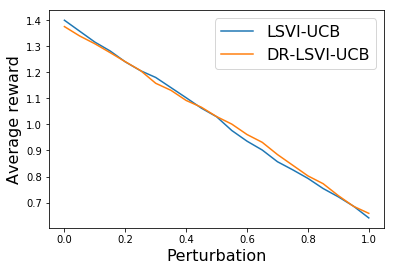

In [28]:
Perturbation = [x / 20 for x in range(21)]
T2 = 100
R_LSVI_UCB = []
R_DR_LSVI_UCB = []
env = LinearMDP_train(action_space, delta, xi_norm)
for q in Perturbation:
    REWARD = 0
    REWARD_DR = 0
    for rep in range(replication):
        reward = 0
        reward_DR = 0
        env_test = LinearMDP_test(env, q=q, seed=rep)
        env_test_DR = LinearMDP_test(env, q=q, seed=rep)
        agent = agent_dic[str(rep)]
        DR_agent = DR_agent_dic[str(rep)]
        
        for t in range(T2):
            env_test.reset()
            env_test_DR.reset()
            for h in range(H):
                current_state = env_test.current_state
                phi = [env_test.phi(current_state, a) for a in action_space]
                action = agent.get_action(phi, h)

                current_state_DR = env_test_DR.current_state
                phi_DR = [env_test_DR.phi(current_state_DR, a) for a in action_space]
                action_DR = DR_agent.get_action(phi_DR, h)
                
                env_test.step(action)
                env_test_DR.step(action_DR)
            reward += np.sum(env_test.R)/T2
            reward_DR += np.sum(env_test_DR.R)/T2
        REWARD += reward / replication
        REWARD_DR += reward_DR / replication

    R_LSVI_UCB.append(REWARD)
    R_DR_LSVI_UCB.append(REWARD_DR)
plt.plot(Perturbation, R_LSVI_UCB, label = 'LSVI-UCB')
plt.plot(Perturbation, R_DR_LSVI_UCB, label = 'DR-LSVI-UCB')
plt.legend(fontsize=16)
plt.xlabel('Perturbation', size=16)
plt.ylabel('Average reward', size=16)
plt.savefig(f'robustness_{delta}_{xi_norm}_{rho}.pdf', dpi=1000, bbox_inches='tight', pad_inches=0.0)